# Argo one filter scale

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import cartopy.crs as ccrs
import cartopy
import xrft
import scipy
import matplotlib

### Things to work on:
- Compare Dhruv's rigourous filtering method from the Filtering_and_Fourier_transforms repo to my functions that use scipy.gaussian_filter1d. Are the results identical?
- Use these functions to perform the above calculations about "MKE" and "EKE" on one scale:
    - Pass temperature signal through filter at l=100m, then square the results <-- MKE
    - Square the temperature signal, pass it through filter at l=100m, then subtract MKE <-- EKE

### Load and plot data

In [2]:
import my_stats

In [4]:
#glider data
ds_660_grid = xr.open_dataset('ctd_660_vert_4m_binned_29_june_2021.nc')
gselect=ds_660_grid.sel(dives=slice(50,450),ctd_pressure=slice(200,900))
gselect_filt=my_stats.glider_ds_filt(gselect,1,4,50)
gselect_var=my_stats.glider_var(gselect,gselect_filt)

#argo box
box=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")
aselect=my_stats.get_ds_interp(box,200,2000,4)
aselect_filt=my_stats.get_ds_filt(aselect,1,4,50)
aselect_var=my_stats.get_var(aselect,aselect_filt)

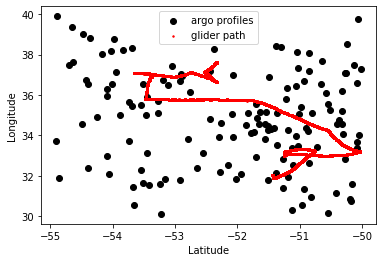

In [5]:
plt.scatter(aselect.LATITUDE,aselect.LONGITUDE,color='black',label='argo profiles')
plt.scatter(gselect.latitude,gselect.longitude,color='r',s=2,label='glider path')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

Text(0.5, 1.0, 'Argo Box')

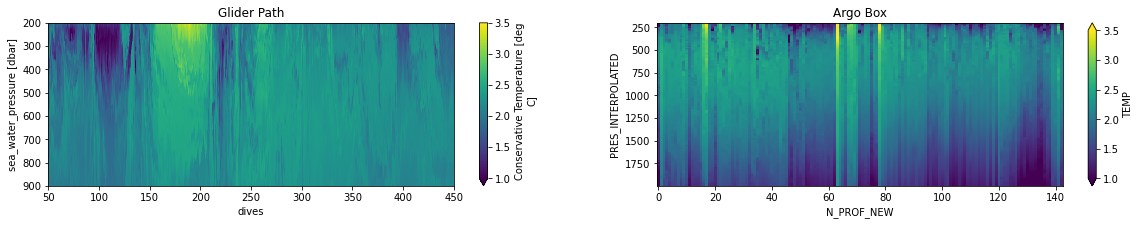

In [6]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
gselect.CT.plot(x='dives',y='ctd_pressure',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Glider Path')

plt.subplot(1,2,2)
aselect.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

## Dhruv's filtering methods/functions

In [7]:
import funcs

In [59]:
#I'm not sure that I defined dx and N correctly for this dataset

dx = (aselect.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=1)-aselect.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0)).values
N = len(aselect.PRES_INTERPOLATED) +1
lfilter = 50*dx
sigmafilter = lfilter/np.sqrt(12)

nfilter_hat = lfilter/dx 
nfilter_gauss = sigmafilter/dx

f_hat = funcs.top_hat_kernel(nfilter_hat, N/2-1)
f_gauss = funcs.gaussian_kernel(nfilter_gauss, N/2-1)

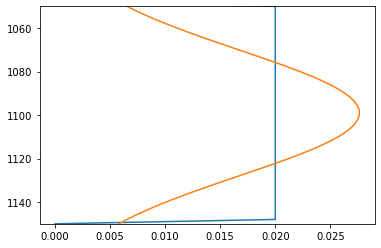

In [63]:
x=aselect.PRES_INTERPOLATED

plt.plot(f_hat, x)
plt.plot(f_gauss, x)
plt.ylim(1050,1150)
plt.gca().invert_yaxis()
#plt.ylabel('PRES_INTERPOLATED [m]')

In [64]:
f = aselect.TEMP.isel(N_PROF=0)
f_num = int(f.N_PROF)

f_l_hat = funcs.my_filter1d(f.values, nfilter_hat, funcs.top_hat_kernel, mode='wrap')
f_l_gauss = funcs.my_filter1d(f.values, nfilter_gauss, funcs.gaussian_kernel, mode='wrap')

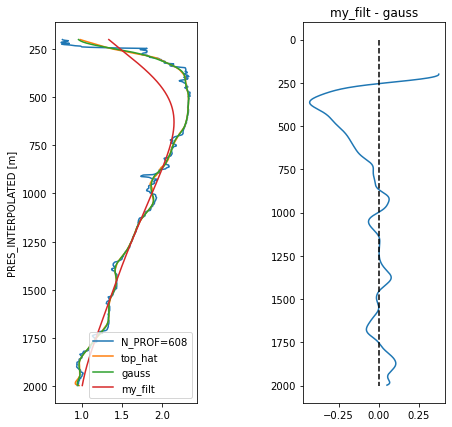

In [79]:
plt.figure(figsize=(7,7))

plt.subplot(1,2,1)
plt.plot(f, x, label='N_PROF={}'.format(f_num))
plt.plot(f_l_hat, x, label='top_hat')
plt.plot(f_l_gauss, x, label='gauss')
plt.plot(aselect_filt.sel(N_PROF=f_num).isel(FILT_SCALE=35), x, label='my_filt')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.legend()

plt.subplot(1,2,2)
plt.plot(aselect_filt.sel(N_PROF=f_num).isel(FILT_SCALE=35)-f_l_gauss, x)
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title('my_filt - gauss')

plt.subplots_adjust(wspace=0.75)

There are obviously some differences between Dhruv's functions and mine. Need to combine the functionality of both:
- Dhruv's functions: use this method to determine dx, N, etc. Function should read in filter scale input of meters.
- My functions: use this method to repeatedly filter at multiple scales. Function should return a nicely formatted xr array.

## Correcting my get_ds_interp function

In [85]:
def gaussian_kernel(sigma, radius):
    """
    Computes a 1D Gaussian convolution kernel.
    """
    
    p = np.polynomial.Polynomial([0, 0, -0.5 / (sigma * sigma)])
    
    x = np.arange(-radius, radius + 1)
    
    # E^(p(x))
    phi_x = np.exp(p(x), dtype=np.double)
    
    # normalization
    phi_x /= phi_x.sum()
        
    return phi_x

def my_filter1d(f, sigma, kernel, mode='wrap', truncate=4.0):
    """ wrapper function for convolve"""
    lw = int(truncate * float(sigma) + 0.5)
    weights = kernel(sigma, lw)
    
    return convolve1d(f, weights, mode = mode)

In [ ]:
#existing function:
def get_ds_filt(ds_interp,first,last,num,variable='TEMP'):
    temp_sigmas=np.logspace(first,last,num)
    sigmas=np.empty(num)
    
    for n,sig in enumerate(temp_sigmas):
        sigmas[n]=sig/4/np.sqrt(12)
    
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))
    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds_filt.N_PROF.dims)
    return ds_filt

In [ ]:
#one_filt_scale(ds_interp, first, last, num, variable='TEMP', boundary_correction=False):

ds_interp = 
scale = 100

dx = (ds_interp.PRES_INTEROLATED.isel(PRESINTEROLATED=1)-ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0)).values
N = len(ds_interp.PRES_INTERPOLATED)+1
lfilter = 
sigmafilter = lfilter/np.sqrt(12)
nfilter = sigmafilter/dx
f_l = my_filter1d(ds_interp, nfilter, gaussian_kernal, mode='wrap')

## MKE/EKE method from Steinberg paper

These eqations are for energy at one spatial scale, where the eddy kinetic energy at scales smaller than the filter scale (EKE) and mean kinetic energy at scales larger than the filter scale (MKE) are:

$$
MKE = <u>^2
$$
$$
EKE = <u^2> - <u>^2
$$

(based on this paper: [Steinberg](https://journals.ametsoc.org/view/journals/phoc/52/8/JPO-D-21-0269.1.xml))

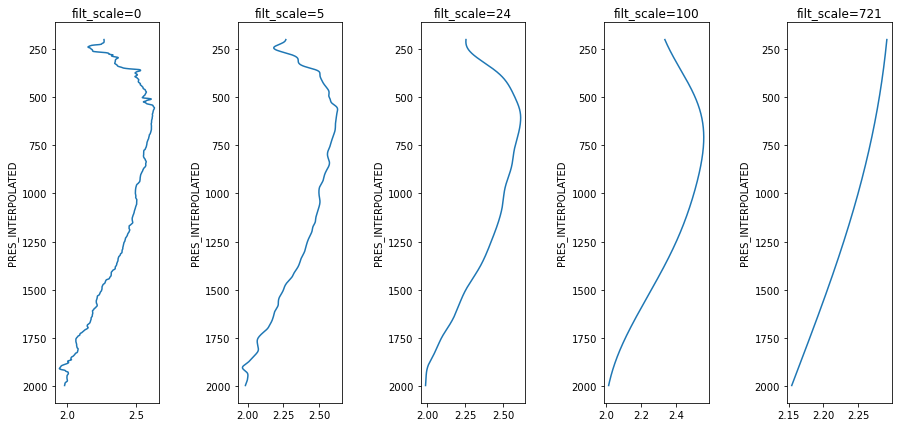

In [12]:
#this is with my_stats functions!

plt.figure(figsize=(15,7))

plt.subplot(1,5,1)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=0).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=0))))

plt.subplot(1,5,2)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=15).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=15))))

plt.subplot(1,5,3)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=25).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=25))))

plt.subplot(1,5,4)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=35).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=35))))

plt.subplot(1,5,5)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=-1).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=-1))))

plt.subplots_adjust(wspace=0.75)

In [175]:
l=35
aselect_filt_l=aselect_filt.isel(FILT_SCALE=l)

MKE=aselect_filt_l**2

Text(0.5, 1.0, 'Argo Box')

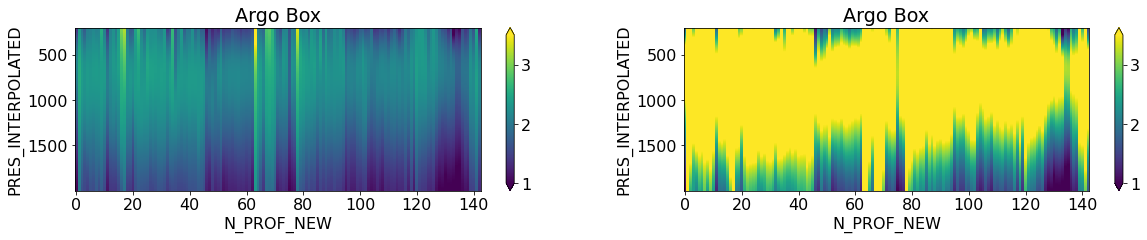

In [190]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
aselect_filt_l.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

plt.subplot(1,2,2)
MKE.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

In [ ]:
#need to square signal, then filter this
#running into problems because get_ds_filt assumes it's reading in full array
####not just the TEMP info
u2 = aselect.TEMP**2
u2_filt = 

#EKE = u2_filt - MKE

In [ ]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
aselect_filt_l.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

plt.subplot(1,2,2)
EKE.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')